# This notebook looks at the DOE of SOLD libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from scipy.spatial.distance import hamming

amino_acids = list(IUPACData.protein_letters)


import doe_utils


# For simulation, create a random parent amino acid sequence to create SOLD libraries from

In [2]:
length_of_protein = 100
parent = ''.join(np.random.choice(amino_acids, length_of_protein))
print("Parent protein:", parent) 

Parent protein: AMQKGPLERMNDTIYFWKSATLINYYFDTSIMKYKIKMTSHPDSMCNKVYVWSSEHGNESARGPRWSQTQHHYAGRTDKECAEDEICKRWMMKTEAMFIP


# Need to create a matrix of postion vs letters

In [3]:
num_mutated = 20 
mutated_pos = np.sort(np.random.choice(range(length_of_protein), num_mutated))
print(mutated_pos) 

[ 0  3  7 20 22 35 35 38 39 41 46 46 53 54 64 76 79 79 85 94]


## For every poisiton to mutate choose a few amino acids to mutate to, with parent amino acid at that pos. to be most probable 

In [4]:
random_muts = [] 
num_muts = 3 
parent_prob = 0.85
mut_probs = [0.05, 0.05, 0.05] # I am keeping it simple here 
assert np.sum(mut_probs) + parent_prob == 1

mut_dict = defaultdict(dict) 
for i in mutated_pos: 
    draws = list(amino_acids) 
    draws.remove(parent[i]) 
    to_draw = np.random.choice(draws, num_muts, replace = False) 
    mut_dict[int(i)] = {parent[i]: parent_prob} 
    for k,l in enumerate(to_draw):
        mut_dict[int(i)].update({str(l): mut_probs[k]})

In [5]:
# Create mutation matrix 
sold_mat = np.zeros((len(amino_acids), length_of_protein))
for k,v in mut_dict.items(): 
    for base, prob in v.items(): 
        sold_mat[amino_acids.index(base), k] = prob


sold_mat_df = pd.DataFrame(sold_mat, index = amino_acids, columns = np.arange(length_of_protein))
sold_mat_df.head() 

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,...,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
C,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
D,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
E,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.85,0.0,0.0,...,0.0,0.0,0.0,0.0,0.85,0.0,0.0,0.0,0.0,0.0
F,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


# Plot the SOLD matrix 

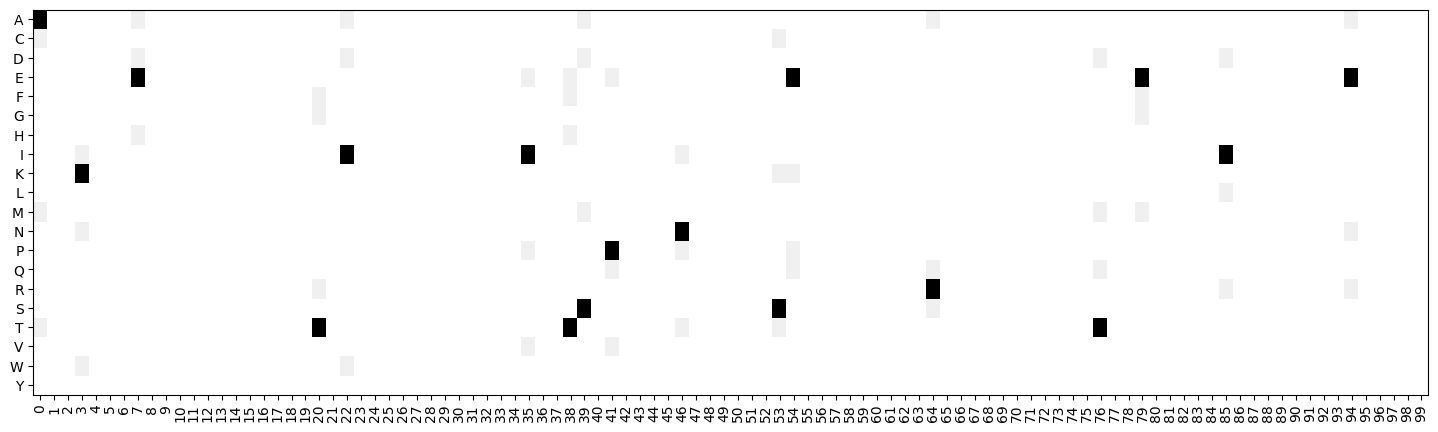

In [6]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(amino_acids)), amino_acids)


# Now let's try to draw mutated sequences from this matrix 
## Above I have created a simple SOLD mat, but I want to make tools such that everything below will work with any experimentaliat provided SOLD mat

In [7]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(1000)

In [8]:
a= S.compute_prob_n_mutations(10)

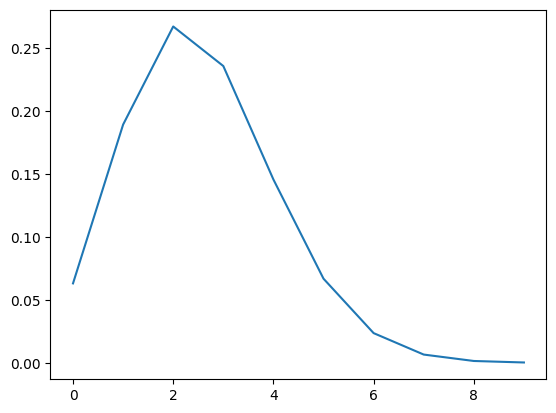

In [9]:
plt.plot(a)

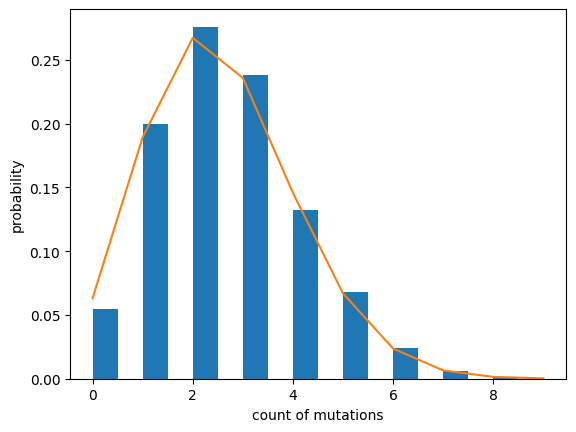

In [29]:
plt.hist(mutations, bins= np.array(range(10)), density = True, align = "mid", width = 0.5) 
plt.ylabel('probability')
plt.xlabel('count of mutations') 
plt.plot(a)

# Now create simulated indel activity with single muation and multi-mutation (epistatic) effects 

In [ ]:
# Given a mutational landscape defined by a SOLD matric we want to create a simulator that assigns individual, 
# epistatic and effects 

In [31]:
# Run SOLD mat through the class to get the positions mutated and what muations can be observed 
S.mutation_probs

defaultdict(dict,
            {0: {'A': 0.85, 'C': 0.05, 'M': 0.05, 'T': 0.05},
             3: {'I': 0.05, 'K': 0.85, 'N': 0.05, 'W': 0.05},
             7: {'A': 0.05, 'D': 0.05, 'E': 0.85, 'H': 0.05},
             20: {'F': 0.05, 'G': 0.05, 'R': 0.05, 'T': 0.85},
             22: {'A': 0.05, 'D': 0.05, 'I': 0.85, 'W': 0.05},
             35: {'E': 0.05, 'I': 0.85, 'P': 0.05, 'V': 0.05},
             38: {'E': 0.05, 'F': 0.05, 'H': 0.05, 'T': 0.85},
             39: {'A': 0.05, 'D': 0.05, 'M': 0.05, 'S': 0.85},
             41: {'E': 0.05, 'P': 0.85, 'Q': 0.05, 'V': 0.05},
             46: {'I': 0.05, 'N': 0.85, 'P': 0.05, 'T': 0.05},
             53: {'C': 0.05, 'K': 0.05, 'S': 0.85, 'T': 0.05},
             54: {'E': 0.85, 'K': 0.05, 'P': 0.05, 'Q': 0.05},
             64: {'A': 0.05, 'Q': 0.05, 'R': 0.85, 'S': 0.05},
             76: {'D': 0.05, 'M': 0.05, 'Q': 0.05, 'T': 0.85},
             79: {'E': 0.85, 'F': 0.05, 'G': 0.05, 'M': 0.05},
             85: {'D': 0.05, 'I': 0.85, 

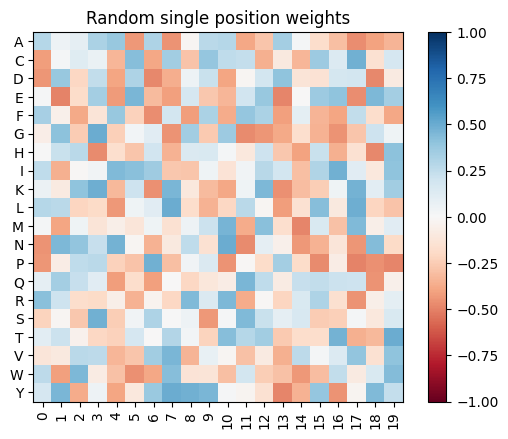

In [45]:
# assign random values (weights) to all individual, pairwise, triplet etc. 

single_weights = np.random.rand(len(amino_acids), num_mutated) - 0.5
plt.imshow(single_weights, vmin = -1, vmax = 1, cmap = 'RdBu') 
_  = plt.xticks(range(num_mutated), rotation = 90)
_  = plt.yticks(range(len(amino_acids)), amino_acids)
plt.title("Random single position weights") 
plt.colorbar() 

In [33]:
# 

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (6, 7),
 (6, 8),
 (6, 9),
 (7, 8),
 (7, 9),
 (8, 9)]